Este projeto tem por objetivo criar uma base e rotulá-la e aplicar o treinamento da rede Yolo.

O objetivo é que no final do código tenhamos algo semelhante à imagem, os objetos detectados e classificados.


(English Translate)


This project aims to create a dataset, label it, and perform training using the YOLO network.

The ultimate goal is to achieve a result similar to the image below, with objects correctly detected and classified

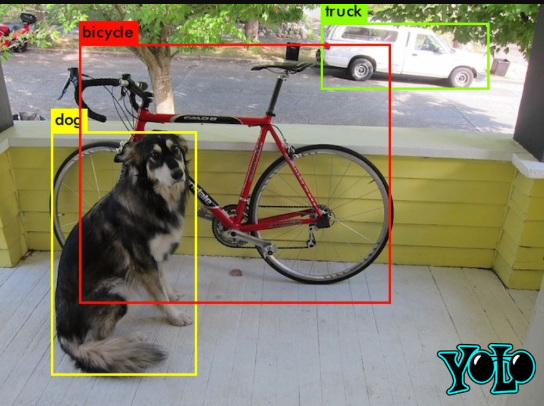

O primeiro passo é importar as bibliotecas que serão utilizadas ao longo do código

(English Translate)

The first step is to import the libraries that will be used throughout the code.

In [ ]:
# 1) Instalar dependências
!pip -q install ultralytics pycocotools opencv-python tqdm pyyaml

# 2) Imports
import os, zipfile, shutil, urllib.request
from tqdm import tqdm
from pycocotools.coco import COCO
import yaml
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


Precisamos que ter acesso ao drive, já que estamos usano o Google Colab

(English Translate)

We need to access the drive, since we are using Google Colab.

In [ ]:
# Acesso ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Configuração para obter apenas 3 classes do dataset "person", "bicycle", "dog".
Como o DB é muito grande a configuração para o treinamento é de 300 imagens e  validação com 60 imagens (onde teremos aproximadamente 80% de treino e 30 % de validação) e salva o minidataset (apenas com esses 3 tipos de imagens).


(English Translate)

Configure the download for only 3 classes: 'person', 'bicycle', and 'dog'. Since the DB is very large, the training setup consists of 300 images and validation with 60 images (approximately 80% for training and 20% for validation), saving the minidataset with only these 3 categories.



In [ ]:
# -----------------------------
# CONFIG
# -----------------------------
CLASSES = ["person", "bicycle", "dog"]

# deixe pequeno pra rodar rápido; depois você aumenta se quiser
MAX_TRAIN = 300
MAX_VAL   = 90
EPOCHS    = 5

BASE_DIR = "/content/coco_mini"
IMG_DIR  = f"{BASE_DIR}/images"
ANN_DIR  = f"{BASE_DIR}/annotations"

OUT_ROOT = "/content/coco_mini_yolo"

DRIVE_SAVE_DIR = "/content/drive/MyDrive/YOLO_COCO_MINI_3CLASSES"
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(ANN_DIR, exist_ok=True)

Faz o download do dataset (DB = Database) do Coco, pega apenas as imagens específicas

(English Translate)

Download the COCO dataset (DB) and extract only specific images

In [ ]:
# -----------------------------
# (A) Baixar só anotações COCO
# -----------------------------
ann_zip = f"{ANN_DIR}/annotations_trainval2017.zip"
ann_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

train_json = f"{ANN_DIR}/annotations/instances_train2017.json"
val_json   = f"{ANN_DIR}/annotations/instances_val2017.json"

if not (os.path.exists(train_json) and os.path.exists(val_json)):
    print("📥 Baixando anotações COCO...")
    if not os.path.exists(ann_zip):
        urllib.request.urlretrieve(ann_url, ann_zip)
    print("📦 Extraindo anotações...")
    with zipfile.ZipFile(ann_zip, "r") as z:
        z.extractall(ANN_DIR)
print("✅ Anotações OK.")

# -----------------------------
# (B) Baixar imagens mini (apenas as necessárias)
# -----------------------------
def download_images(split, coco_json, max_imgs):
    coco = COCO(coco_json)
    cat_ids = coco.getCatIds(catNms=CLASSES)
    if len(cat_ids) != len(CLASSES):
        found = [c["name"] for c in coco.loadCats(cat_ids)]
        raise ValueError(f"Classes COCO não encontradas. Achou: {found}. Esperado: {CLASSES}")

    img_ids = coco.getImgIds(catIds=cat_ids)[:max_imgs]
    out_dir = os.path.join(IMG_DIR, split)
    os.makedirs(out_dir, exist_ok=True)

    print(f"📥 Baixando {split} ({len(img_ids)} imgs)...")
    for img_id in tqdm(img_ids, desc=f"Download {split}"):
        info = coco.loadImgs(img_id)[0]
        out_path = os.path.join(out_dir, info["file_name"])
        if not os.path.exists(out_path):
            urllib.request.urlretrieve(info["coco_url"], out_path)

# baixa se ainda estiver vazio
if not os.path.exists(os.path.join(IMG_DIR, "train")) or len(os.listdir(os.path.join(IMG_DIR, "train"))) < 10:
    download_images("train", train_json, MAX_TRAIN)
else:
    print("✅ Train já baixado (pulando).")

if not os.path.exists(os.path.join(IMG_DIR, "val")) or len(os.listdir(os.path.join(IMG_DIR, "val"))) < 5:
    download_images("val", val_json, MAX_VAL)
else:
    print("✅ Val já baixado (pulando).")

✅ Anotações OK.
✅ Train já baixado (pulando).
✅ Val já baixado (pulando).


Conversão das imagens do coco para lables (como funciona a biblioteca Yolo)

(English Translate)

Converting COCO images to labels (how the YOLO library works)

In [ ]:
# -----------------------------
# (C) Converter COCO -> YOLO (labels)
# -----------------------------
def coco_bbox_to_yolo(bbox, img_w, img_h):
    x, y, w, h = bbox
    xc = x + w/2.0
    yc = y + h/2.0
    return (xc/img_w, yc/img_h, w/img_w, h/img_h)

def make_yolo_split(split, coco_json, img_src, out_root):
    coco = COCO(coco_json)
    cat_ids = coco.getCatIds(catNms=CLASSES)
    cats = coco.loadCats(cat_ids)
    coco_id_by_name = {c["name"]: c["id"] for c in cats}

    yolo_to_coco = [coco_id_by_name[name] for name in CLASSES]
    coco_to_yolo = {coco_id: i for i, coco_id in enumerate(yolo_to_coco)}

    out_img = os.path.join(out_root, "images", split)
    out_lbl = os.path.join(out_root, "labels", split)
    os.makedirs(out_img, exist_ok=True)
    os.makedirs(out_lbl, exist_ok=True)

    files = set(os.listdir(img_src))
    img_ids_all = coco.getImgIds(catIds=cat_ids)

    img_ids = []
    for img_id in img_ids_all:
        info = coco.loadImgs(img_id)[0]
        if info["file_name"] in files:
            img_ids.append(img_id)

    for img_id in tqdm(img_ids, desc=f"COCO->YOLO {split}"):
        info = coco.loadImgs(img_id)[0]
        fn = info["file_name"]
        w, h = info["width"], info["height"]

        src_img = os.path.join(img_src, fn)
        dst_img = os.path.join(out_img, fn)
        if os.path.exists(src_img) and not os.path.exists(dst_img):
            shutil.copy2(src_img, dst_img)

        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=cat_ids)
        anns = coco.loadAnns(ann_ids)

        lines = []
        for a in anns:
            cid = a["category_id"]
            if cid not in coco_to_yolo:
                continue
            xycwh = coco_bbox_to_yolo(a["bbox"], w, h)
            if xycwh[2] <= 0 or xycwh[3] <= 0:
                continue
            cls = coco_to_yolo[cid]
            lines.append(f"{cls} {xycwh[0]:.6f} {xycwh[1]:.6f} {xycwh[2]:.6f} {xycwh[3]:.6f}")

        with open(os.path.join(out_lbl, os.path.splitext(fn)[0] + ".txt"), "w") as f:
            f.write("\n".join(lines))

# recria só o dataset YOLO (não apaga coco_mini)
if os.path.exists(OUT_ROOT):
    shutil.rmtree(OUT_ROOT)

make_yolo_split("train", train_json, os.path.join(IMG_DIR, "train"), OUT_ROOT)
make_yolo_split("val",   val_json,   os.path.join(IMG_DIR, "val"),   OUT_ROOT)

# -----------------------------
# (D) data.yaml
# -----------------------------
yaml_path = os.path.join(OUT_ROOT, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.safe_dump({
        "path": OUT_ROOT,
        "train": "images/train",
        "val": "images/val",
        "names": {i: n for i, n in enumerate(CLASSES)}
    }, f, sort_keys=False)

print("✅ Dataset YOLO pronto:", OUT_ROOT)

loading annotations into memory...
Done (t=40.82s)
creating index...
index created!


COCO->YOLO train: 100%|██████████| 112/112 [00:00<00:00, 317.48it/s]


loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


COCO->YOLO val: 100%|██████████| 7/7 [00:00<00:00, 265.26it/s]

✅ Dataset YOLO pronto: /content/coco_mini_yolo


Realiza o treinamento e salva

(English Translate)

The script performs the training and then saves the weights or the entire model to a file

In [ ]:

# -----------------------------
# (E) Treinar (rápido) e salvar no Drive
# -----------------------------
PROJECT_DIR = "/content/runs"
RUN_NAME = "coco_mini_3classes"

model = YOLO("yolov8n.pt")
model.train(
    data=yaml_path,
    epochs=EPOCHS,
    imgsz=640,
    batch=8,
    workers=2,
    project=PROJECT_DIR,
    name=RUN_NAME
)

best_pt = os.path.join(PROJECT_DIR, RUN_NAME, "weights", "best.pt")
last_pt = os.path.join(PROJECT_DIR, RUN_NAME, "weights", "last.pt")

# salva no Drive (best se existir, senão last)
if os.path.exists(best_pt):
    shutil.copy2(best_pt, os.path.join(DRIVE_SAVE_DIR, "best.pt"))
    MODEL_TO_USE = os.path.join(DRIVE_SAVE_DIR, "best.pt")
elif os.path.exists(last_pt):
    shutil.copy2(last_pt, os.path.join(DRIVE_SAVE_DIR, "last.pt"))
    MODEL_TO_USE = os.path.join(DRIVE_SAVE_DIR, "last.pt")
else:
    raise FileNotFoundError("Não encontrei best.pt nem last.pt após o treino.")

print("💾 Modelo salvo no Drive:", MODEL_TO_USE)



Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/coco_mini_yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=coco_mini_3classes2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

Para validar se o algoritmo está funcionando, basta inserir o caminho da inmagem na variável "EXTERNAL_IMAGE_PATH" e verá o resultado na tela.

A variável "conf" significa o nível de confiança de detecção. Para casos experimentais (exploração, temos um nível de confiança aceitável) uma vez que estamos trabalhando com 3 categorias poucas épocas e poucos dados.
Uma vez trabalhado, inserindo mais dados, mais épocas de treinamento mais imagens para treino e validação, o nível de confiança tende a melhorar mas, para isso precisaríamos de um poder computacional maior.

(English Translate)

To validate if the algorithm is working, simply insert the image path into the 'EXTERNAL_IMAGE_PATH' variable to see the result on the screen.

The 'conf' variable represents the detection confidence level. For experimental purposes, we have an acceptable confidence level since we are working with three categories, few epochs, and limited data. Once refined—by adding more data, more training epochs, and more images for training and validation—the confidence level tends to improve; however, this would require greater computational power.

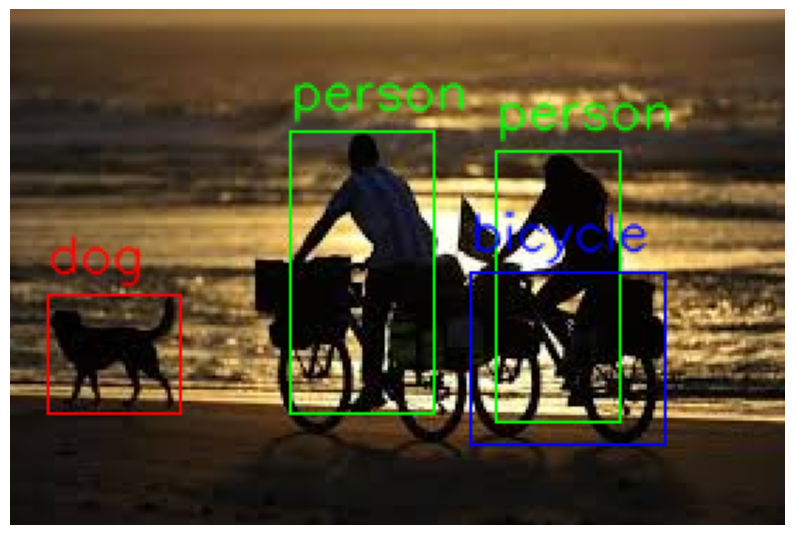

In [ ]:
# -----------------------------
# (F) Inferência
# -----------------------------

EXTERNAL_IMAGE_PATH = '/content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/BASE_DE_DADOS_YOLO/Validacao_Yolo_2.jpg'    # inserir o caminho da imagem as servalidada

# Carrega o modelo treinado
trained = YOLO(MODEL_TO_USE)

# Verifica se a imagem existe
if not os.path.exists(EXTERNAL_IMAGE_PATH):
    raise FileNotFoundError(f"Imagem externa não encontrada: {EXTERNAL_IMAGE_PATH}")

# Executa a inferência
result = trained.predict(
    source=EXTERNAL_IMAGE_PATH,
    conf = 0.1,   # Nivel de Confiança da imagem
    save=False,
    verbose=False
)[0]


# Lê a imagem (BGR)
img = cv2.imread(EXTERNAL_IMAGE_PATH)

# Cores POR CLASSE em BGR (OpenCV)
CLASS_COLORS = {
    "person":  (0, 255, 0),    # verde
    "bicycle": (255, 0, 0),    # azul
    "dog":     (0, 0, 255)     # vermelho
}

# Parâmetros visuais
BOX_THICKNESS  = 1      # espessura da bounding box
FONT_SCALE     = 0.41   # tamanho do texto
FONT_THICKNESS = 1      # espessura do texto


# Desenha bounding boxes + labels (EM BGR)
for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    class_id = int(box.cls[0].item())
    label = CLASSES[class_id]

    color = CLASS_COLORS[label]

    cv2.rectangle(img, (x1, y1), (x2, y2), color, BOX_THICKNESS)
    cv2.putText(
        img,
        label,
        (x1, max(20, y1 - 8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        color,
        FONT_THICKNESS,
        cv2.LINE_AA
    )

# AGORA SIM converte para RGB só para exibir
import matplotlib.pyplot as plt
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 7))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

